# Multicast, broadcast, and multiple kernels in a single compute tile

## Goals

* Explore dataflow communication between neighboring and non-neighboring compute tiles

* Understand the multicast and broadcast capabilities of the NPU array

* Learn about running multiple kernels in one AI Engine compute tile

* Understand the performance implications of different ways of moving data 

## References

**[Multicasting](https://en.wikipedia.org/wiki/Multicast)**

**[Load Balancing](https://en.wikipedia.org/wiki/Load_balancing_(computing))**

---


## Multicast Data Using the Data Movers

A new color detection application will be used to demonstrate the multicast data movement capabilities of the NPU. This algorithm identifies those pixels in an input video stream whose color values fall within specified ranges and highlights them. 

This is an example of what we refer to as a *branched dataflow*. *Branch* in this instance means that the same data is sent to multiple kernels.  There are two such branches in the dataflow graph below. The first is at the output of the input buffer and the second is at the output of the rgb2hsv node.

In contrast to the earlier scaled color threshold application, where data was partitioned before being sent to individual kernels, this application dispatches the same data to multiple kernels. When executing the application, you will be able to specify the color ranges and see their effects.

<center><img src="./images/png/color_detect_dfg.png" style="max-height: 250px; width:auto; height:auto;"></center>
<center><strong>Color detection logical pipeline</strong></center>

The application has four kernels which will map to four kernels. Each kernel will be mapped to one compute tile. 

* `rgb2hsv` - convert RGB to [hue-saturation-value](https://en.wikipedia.org/wiki/HSL_and_HSV) (HSV) color format
* `inRange0` - checks for pixels in the first hue range 
* `inRange1` - checks for pixels in the second hue range
* `mask` - pixels that fall outside the specified range are set to black, otherwise the pixel is not modified

[HSV color space](https://en.wikipedia.org/wiki/HSL_and_HSV) is used as the pixel HUE will be used to specify the color range for pixels. 

From the dataflow graph, you can see the input data stream is multicast to the `rgb2hsv` and the `mask` kernels. The output HSV data from `rgb2hsv` is also multicast and streamed to the two `inRange` kernels. Unlike in cached architectures where this multicast could lead into two independent copies, the NPU has dedicated hardware to handle broadcast efficiently via the network stream interconnect.

The NPU also has [broadcast](https://en.wikipedia.org/wiki/Broadcasting_(networking)) capabilities enabled via the network of stream interconnect.

In the image below you can see the result of the color detection algorithm for a particular set of range values.


<center><img src="./images/png/toucan_color_detect.png" style="max-height: 420px; width:auto; height:auto;"></center>
<center><strong>Color detection algorithm</strong></center>


<div class="alert alert-box alert-success">
    The NPU array has efficient support for multicast and broadcast of data.
</div>

## Run the application

Image(value=b'', format='jpeg')

Button(description='Stop', style=ButtonStyle())

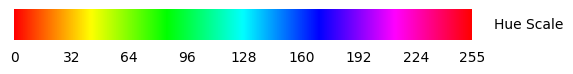

In [1]:
from npu.lib import ColorDetectVideoProcessing

app = ColorDetectVideoProcessing()
app.start()

<div class="alert alert-box alert-warning">
    After you have explored the application, click the <strong>Stop</strong> button to finish the video stream and release the NPU and webcam
</div>


---


## Dataflow Mapping

You can see that due to branching, we have three paths in the dataflow diagram which converge on the `mask` kernel node. This node has three inputs. To maximize performance, we need to provide all three input data streams to this node simultaneously. Given that this design will use a single column of the array, regardless of how we map the kernels, only two tiles can use nearest neighbor connectivity. Some tiles will need to transfer data to non-neighboring tiles. This example will use a combination of data movers and the streaming interconnect, and also nearest neighbor data memory sharing.

In the animations below, we show one way the application can be mapped to the array. The data movement will be broken down into smaller steps before the final version of the application mapping is shown.

<table border="0" width="75%" style="border: 0px; background:white">
    <tr style="border: 0px; background:white">
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 1</strong></td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 2</strong></td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 3</strong></td>
    </tr>    
    <tr style="border: 0px;">
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;">
            <img src="./images/svg/trailer_example_step1_if_tile.svg" style="max-height:750px; width:auto; height:auto;">
        </td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;">
            <img src="./images/svg/trailer_example_step1_mem_tile.svg" style="max-height:750px; width:auto; height:auto;">
        </td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;">
            <img src="./images/svg/trailer_example_step3_aie0_data_push.svg" style="max-height:750px; width:auto; height:auto;">
        </td>
    </tr>
    <tr style="border: 0px; background:white">
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 1</strong></td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 2</strong></td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 3</strong></td>
    </tr>
</table>

- Step 1
    * the interface tile moves a column of data from system memory to the data memory in the memory tile.
- Step 2
    * in the memory tile, data movers will multicast the input stream to both the `rgb2hsv` kernel (orange, in the top compute tile) and `mask` kernel (dark orange, in the bottom compute tile). One data mover in the memory tile is used to send the data. Each compute tile uses a data mover to receive the stream. The stream switch in the bottom compute tile moves data (green) to the data memory in this tile and also sends the same data on the streaming interface to the north towards the top compute tile.
- Step 3
    * once the `rgb2hsv` kernel in the top compute tile has enough data in its input buffer it starts executing. It writes its results in its data memory (orange data buffer). This orange buffer is consumed by the `inRange0` kernel (blue) in the next compute tile. The `inRange0` kernel can access the data it needs directly from the memory of the tile to the north. The output from the `rgb2hsv` kernel (orange) is also pushed by the data movers via the streaming interconnect to the `inRange1` (pink) kernel.

<table border="0" width="75%" style="border: 0px; background:white">
    <tr style="border: 0px; background:white">
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 4</strong></td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 5</strong></td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 6</strong></td>
    </tr>    
    <tr style="border: 0px;">
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;">
            <img src="./images/svg/trailer_example_step3_aie1_data_push.svg" style="max-height:750px; width:auto; height:auto;">
        </td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;">
            <img src="./images/svg/trailer_example_step4_aie2_3.svg" style="max-height:750px; width:auto; height:auto;">
        </td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;">
            <img src="./images/svg/trailer_example_full.svg" style="max-height:750px; width:auto; height:auto;">
        </td>
    </tr>
    <tr style="border: 0px; background:white">
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 4</strong></td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 5</strong></td>
        <td style="border: 0px; background:white; text-align: center; vertical-align: middle;"><strong>Step 6</strong></td>
    </tr>
</table>


* Step 4
    * when both `inRange` kernels have enough input data they start executing and producing data (blue and pink data buffers). The blue buffer is pushed by the data mover to the mask kernel (dark orange) using the stream interconnect. Meanwhile the pink buffer can be accessed via nearest-neighbor communication from the tile above.
* Step 5
    * the `mask` kernel can start processing, using the data generated by the `inRange` kernels. Its output buffer, dark orange, is then moved outside of the array via the interface tile.
* Step 6
    * shows the animation for the full example.



<div class="alert alert-box alert-success">
    This application capitalizes on the architectural features of the NPU array to achieve real time performance with very little power consumption.
</div>


---


## NPU Resource Use

In all, the application uses:

* 1 interface tile
  * 2 data movers
    * 1 for stream input and 1 for stream output
* 1 memory tile
  * 1 input data buffer
  * 3 data movers
    * 1 for stream input from the interface tile
    * 2 for stream outputs to the compute tiles
* 4 compute tiles
  * 1 for each of the kernels
  * 8 memory buffers
    * 2 memory buffers at the top tile
      * input from interface tile and results data
    * 1 memory buffers at the second to top tile
    * 2 memory buffers at the third to top tile
      * multicast data from top tile and results
    * 3 memory buffers at the bottom tile
      * input from interface tile, input from second-to-top tile and results data
  * 5 data movers
    * 1 for stream input at the top and bottom compute tiles bottom
    * 1 for multicasting data at the top compute tile
    * 1 for multicasting data at the second-to-top compute tile
    * 1 for stream output at the bottom compute tile



---


## Multiple Kernels in One Tile

Both the dataflow graph and the animations are a simplification of the actual functionality. `inRange` and `mask` kernels are a combination of multiple kernels.  We refer to this combination as a *super kernel*. 

The `inRange` super kernel is a combination of two threshold kernels: one to check for pixel values greater than a threshold and another to check for pixel values less than a threshold.

The `mask` super kernel is a combination of three kernels:  

 1.  `bitwise_or` between the outputs of the `inRange` super kernels
 2. `gray2rgb` to create a color channel mask
 3.  `bitwise_and` operation is performed from the output of the `gray2rgb` kernel and the input image
    

Up to this point, we have assigned one kernel per compute tile. However, the color detection has eight different kernels. So, for this application, we need to map multiple kernels to a single tile.

The compute tile is capable of running multiple kernels, however the execution is sequential and one kernel cannot start until the previous finishes.

The benefit of having multiple kernels in a single tile is that the communication happens using a single buffer. There is no need for ping-pong buffer.

The animation below shows an example of multiple kernels running in one tile. The orange kernel produces data in the orange buffer.  This in turn is consumed by the yellow kernel that produces the yellow data.

<center><img src="./images/svg/multiple_kernels_single_tile.svg" style="max-height: 180px; width:auto; height:auto;"></center>
<center><strong>Multiple kernels in a single tile</strong></center>


---


## Load Balancing

In a case where there are more kernels (nodes in the dataflow graph) than physical compute tiles, the designer needs to decide how to map multiple kernels into a single tile.

Naturally, some kernels can take more time than others. Hence, the idea of [load balancing](https://en.wikipedia.org/wiki/Load_balancing_(computing)) is to distribute the kernels to the compute tiles such that the maximum performance is achieved.

In dataflow applications, the slowest kernel dictates the maximum performance that such an application can achieve.

As a designer, you need to profile the different kernels and then combine them in such a way that each compute tile takes roughly the same amount of time to complete the computation.

The color detection application has been designed and mapped in such a way that each compute tile performs approximately the same amount of compute.


---


## Next Steps

In section 4 you will learn how to write your own kernels as well as the connectivity graph between tiles.


---

<center>
Copyright&copy; 2023 AMD, Inc
</center>
<center>
SPDX-License-Identifier: MIT
</center>